# 移动推荐系统

## 数据读取

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [44]:
with open('./tianchi_fresh_comp_train_user.csv', 'r') as f:
    text_user = f.readlines(10000000)
    
with open('./sub_user.csv', 'w') as f:
    for row in text_user:
        f.write(row)

In [45]:
data = pd.read_csv('./sub_user.csv')
data.head().append(data.tail())

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18
1,10001082,4368907,1,NaN,5503,2014-12-12 12
2,10001082,4368907,1,NaN,5503,2014-12-12 12
3,10001082,53616768,1,NaN,9762,2014-12-02 15
4,10001082,151466952,1,NaN,5232,2014-12-12 11
227261,102889078,305677104,1,NaN,4322,2014-11-27 20
227262,102889078,191417561,1,NaN,4322,2014-11-27 21
227263,102889078,392764381,1,NaN,4520,2014-11-26 02
227264,102889078,251444979,1,NaN,4721,2014-12-08 01
227265,102889078,102434607,3,9rgt0mi,3321,2014-12-12 17


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227266 entries, 0 to 227265
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        227266 non-null  int64 
 1   item_id        227266 non-null  int64 
 2   behavior_type  227266 non-null  int64 
 3   user_geohash   72054 non-null   object
 4   item_category  227266 non-null  int64 
 5   time           227266 non-null  object
dtypes: int64(4), object(2)
memory usage: 10.4+ MB


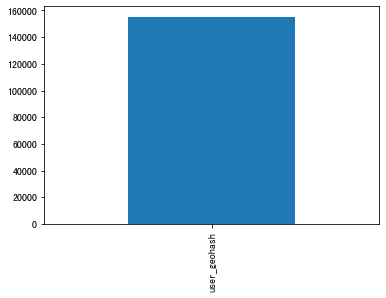

In [47]:
# 空值查看
data.isnull().sum()[data.isnull().sum() != 0].plot(kind='bar')
plt.show()

In [48]:
# 非法值查看
data.select_dtypes(include='object').columns.tolist()

['user_geohash', 'time']

In [49]:
# 空值填充'unknow'
data['user_geohash'].fillna(value='unknow', inplace=True)

# 时间格式转换并设置为index
data.index = pd.to_datetime(data['time'], format='%Y-%m-%d %H')
data.drop('time', axis=1, inplace=True)

## 可视化数据

### 数据分布

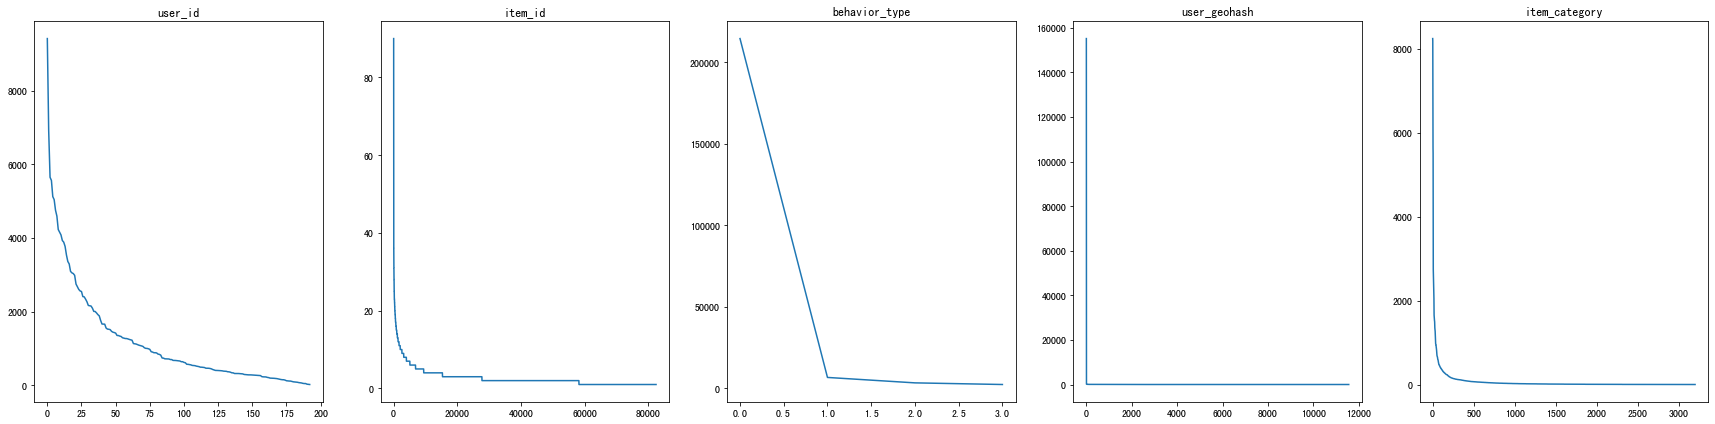

In [50]:
fig, ax = plt.subplots(1, 5, figsize=(30,7))
for idx, column in enumerate(data.columns.tolist()):
    ax[idx].plot(data[column].value_counts().values)
    ax[idx].set_title(column)
plt.show()

### 时间维度查看

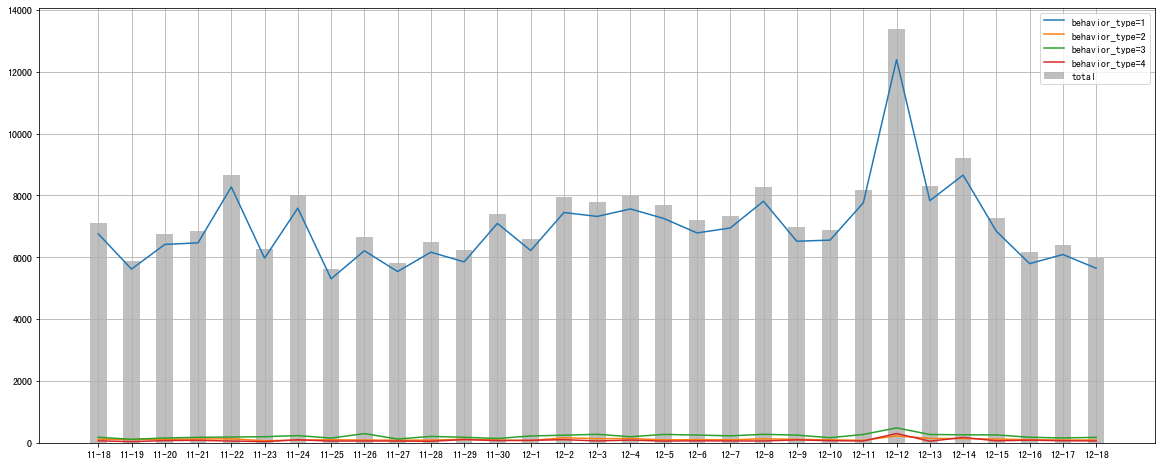

In [51]:
# 按日查看用户行为发生频数
plt.figure(figsize=(20,8))
plt.bar(
    ['{}-{}'.format(x.month, x.day) for x in data.resample('D').count().index], 
    data.resample('D').count()['user_id'],
    label = 'total', color='grey', width=0.5, alpha=0.5
)
for _type, groupby_type in data.groupby('behavior_type'):
    plt.plot(
        ['{}-{}'.format(x.month, x.day) for x in data.resample('D').count().index],
        groupby_type.resample('D').count()['user_id'], label='behavior_type={}'.format( _type)
    )
plt.legend()
plt.grid()
plt.show()

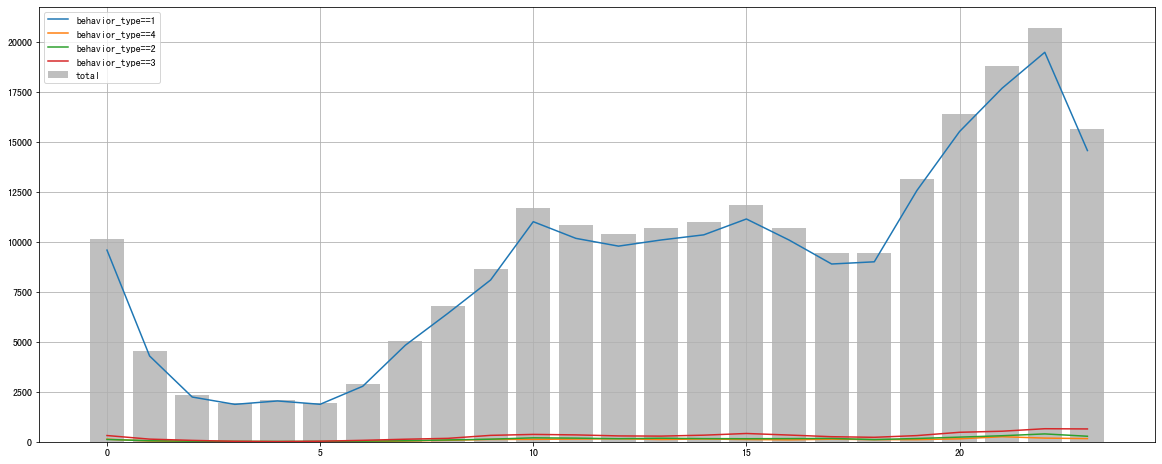

In [52]:
# 按时间查看用户行为
plt.figure(figsize=(20,8))
data_hour = data.copy()
data_hour['new'] = [x.hour for x in data.index]
plt.bar([x for x in range(24)], data_hour.groupby('new').count()['user_id'], alpha=0.5, color='grey', label='total')
for _type in data['behavior_type'].unique().tolist():
    query_str = 'behavior_type=={}'.format(_type)
    plt.plot(data_hour.query(query_str).groupby('new').count()['user_id'], label=query_str)
plt.grid()
plt.legend()
plt.show()

# Rule Based 推荐

查看对已经加入购物车的商品多少天后进行购买，然后针对已经加入购物车未购买的人进行推荐。

## 仅对行为3和4的数据提取

In [55]:
# 设置dataframe
df_rule_based = pd.DataFrame()

# 文件分块读取
chunksize_data = pd.read_csv(
    './tianchi_fresh_comp_train_user.csv', usecols=['user_id', 'item_id', 'behavior_type', 'time'], chunksize=1000000)
for df in chunksize_data:
    result = df.query('behavior_type==3 or behavior_type==4')
    df_rule_based = pd.concat([df_rule_based, result], axis=0)
    
# 删除重复值    
df_rule_based.drop_duplicates(inplace=True)

# 日期格式转换
df_rule_based['time'] = pd.to_datetime(df_rule_based['time'], format='%Y-%m-%d %H')
df_rule_based.head(5)

,user_id,item_id,behavior_type,time
5,10001082,53616768.0,4.0,2014-12-02 15:00:00
61,10001082,220586551.0,4.0,2014-12-14 03:00:00
83,10001082,275221686.0,4.0,2014-12-02 22:00:00
140,10001082,141312432.0,4.0,2014-12-02 16:00:00
212,100029775,287413918.0,4.0,2014-12-13 00:00:00


In [56]:
df_rule_based.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842635 entries, 5 to 23480805
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        842635 non-null  int64         
 1   item_id        842635 non-null  float64       
 2   behavior_type  842635 non-null  float64       
 3   time           842635 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 32.1 MB


## 收藏后延迟购买时间可视化

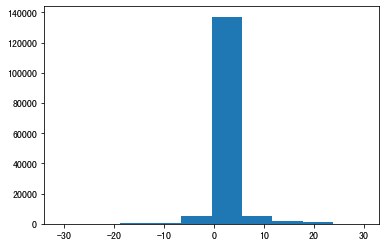

In [111]:
delay_time = []
for user_id, user_id_group in df_rule_based.groupby('user_id'):
    for item_id, item_id_group in user_id_group.groupby('item_id'):
        if len(item_id_group['behavior_type'].value_counts()) > 1:
            item_id_group = item_id_group.sort_values(['behavior_type','time'] , ascending=False)
            for i in range(1, len(item_id_group)):
                if item_id_group.iloc[i]['behavior_type'] == 3.0:
                    de_time = item_id_group.iloc[0]['time'] - item_id_group.iloc[i]['time']
                    delay_time.append(de_time.days)
                    continue
#             print(user_id, item_id)
#             print(item_id_group)
#     a = a + 1
#     if a == 6:
#         break
#             target_dict[user_id].append(item_id)
plt.hist(delay_time)
plt.show()